# Python Machine Learning exercise

Made by Ties van der Heijden, TU Delft

In this exercise we will forecast Day Ahead Market prices of the Dutch market. To achieve this, some feature extraction analysis will be performed. These will then be implemented in a MultiLayer Perceptron from SciKit Learn.

It is recommended to consult the documentation of the functions to find out what parameters are needed for what function.

# Package import

We will start with importing the relevant packages.
These include:
- Numpy
- Pandas
- Scipy

Besides that the following packages are always handy to have imported:
- Pathlib's Path
- Matplotlib
- Seaborn

We will import the following classes immediately, to save ourselves some unnecessary typing:
- MLPRegressor (SKLearn)
- lasso_path (SKLearn)
- plot_acf, plot_pacf (Statsmodels)
- dump (joblib)

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import lasso_path
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from joblib import dump

# Read the data
Panda's function read_csv can be used to load csv files in a DataFrame.<br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

Path can be used robustly declare paths in the directory.<br>
https://docs.python.org/3/library/pathlib.html

In [2]:
path = Path(r'data')
dam = pd.read_csv(path / 'DAM_NL.csv', index_col = 0, parse_dates = True)
load = pd.read_csv(path / 'LOAD_NL.csv', index_col = 0, parse_dates = True)

# Plot the data
The data is imported. You can now use pandas and matplotlib to inspect the data. Pandas daterange objects are ideal for making index-cuts in the DataFrame.

Use Pandas index indicators to plot from 05-03-2018 00:00 untill 13-03-2018 00:00.

Hint: declare a DateRange using pandas Datetime objects. These can be used in combination with the index.isin() function.<br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html <br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html <br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isin.html

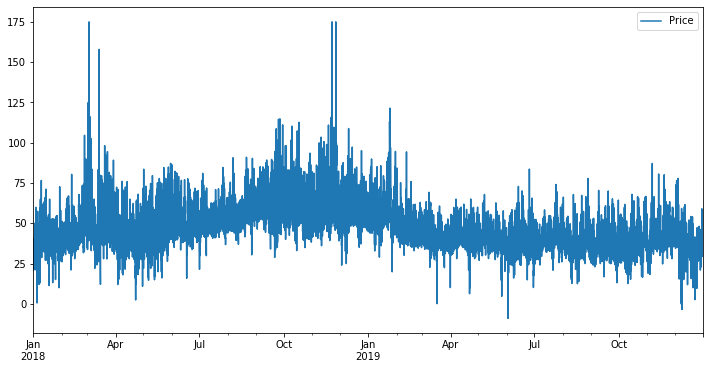

In [3]:
dam.loc[dam.index.year >= 2018].plot(figsize=(12,6))

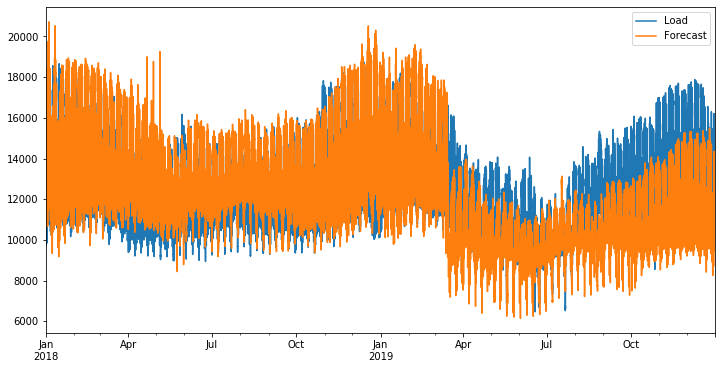

In [4]:
load.loc[load.index.year >= 2018].plot(figsize=(12,6))

# Fill data gaps
The load data also include a day-ahead forecast. Which is exactly what we want when forecasting DAM prices on a day-ahead basis. Scatter plot the Forecast and the Load against each other (Load on X-axis, Forecast on Y-axis).

The DataFrames can contain NaN values. Check for the presence of NaN values, and if present linearly interpolate between the same time of the surrounding days. Keep the datasets as long as possible. Hint: use the index.hour and index.minute functionalities to fill NaN's per time of the day. <br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html

The Load dataframe is in timesteps of 15 minutes, while the DAM is hourly. Resample the Load dataframe to be in hourly resolution as well, but with mean values of the quarterly values. <br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

# Autocorrelation

Let's first look how far we need to look back in the timeseries to make a prediction about the future. This can be done with Autocorrelation and Partial Autocorrelation. Statsmodels has nice functions for that: plot_acf and plot_pacf.

Plot the ACF and PACF of the DAM timeseries with lags up to 14 days.<br>
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html <br>
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html

# LASSO analysis
We observe that autocorrelation can be relevant up to about a week lag. We can use this to limit our data analysis.
Now we find relevant hours using LASSO. LASSO stands for Least Absolute Shrinkage and Selection Operator, which is a regluarization technique we will use to filter out irrelevant lags.

Generally in timeseries regression, historic values are given as seperate features.
These can be passed on in a Numpy Array. Where the rows are the samples and the columns are the features.
In our training-set we don't want to include the target variable (actual price).

Most ML algorithms perform better when the data is standardized. We will apply a Z-score standardization:
Y = (X - mean)/std

1. Scale the DAM and Load forecast data using Z-score standardization.


2. Construct a dataframe where the columns represent lagged (standardized) values of the timeseries.

Column 0 is the actual price, column 1 is one hour shifted in time. And so on, untill t = 168. Hint: use DataFrame.shift(). Make sure you get rid of the resulting NaN values.


3. Create a numpy array with the target variables (Y).


4. Create a numpy array with the lagged prices from 24 - 168 hours for all samples.


5. Use lasso_path to compute the LASSO-coefficients


6. Plot the LASSO-coefficients over the -log of the LASSO-alphas.

Useful links:<br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso <br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html

# Heatmap
Since these plots dont show much overview, let's try a heatmap. Plot a seaborn heatmap with on the x-axis the delayed timesteps, on the y-axis the -log alphas and the color the Lasso coefficients. <br>
https://seaborn.pydata.org/generated/seaborn.heatmap.html

# Feature creation
Some hours seem to stick out in importance. Which ones?
Select the 4 most important lags.

For DAM forecasting we would like to take daily patters into account.
We can do this through Multivariate regression: we forecast all 24 prices at the same time.

Our target matrix, Y, will have a row for every day. And a column for every hour of the day.
Our training matrix, X, will have a row for every day, and a column for all the relevant delayed hours, for all hours of the day. Besides that, the training matrix will include 24 Load forecasts - one for each hour of the day.

Shape target: (N_days, 24)

Shape training: (N_days, 24*n_lags + 24)

- Make the X and Y matrices.

The order of the columns is irrelevant in X, since the algorithm will find relevant relationships.
You can use np.unique() to filter out duplicate columns. <br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html <br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html

# Split the samples
Allmost there. 

In order to evaluate our model we should keep a bit of the data for ourselves, so we can test it on data it hasn't seen before. A rule of thumb is to used 1/3 as test set, and 2/3rds as training set. However, we are going to use a 5-fold cross validation. Where the whole dataset is split into 5 batches, and we train the model 5 times using 1 of the 5 batches to score and the other 4 for training. So we just keep 10% of our data samples out of training.

- Split the X and Y matrices into 1/10th and 9/10th of the samples.

# Hyperparameter search
Now train an MLPRegressor with two hidden layers.

Use GridSearchCV with the following ranges for the nodes/layer:
- nodes in layer 1: range(100, 250, 50)
- nodes in layer 2: range(40, 70, 10)

Use 5-fold cross validation, and set early_stopping to True.

Note: this might take a while to finish. Feel free to play around with extra hyperparameter tuning or feature analysis.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Extract, retrain, forecast and save.
- Extract the best model with the best_estimator_ class.
- Re-train this model with the whole 9/10th of the dataset.
- Forecast the prices on the 1/10th of data you kept from the model.
- Rearrange the daily predictions into an hourly timeserie.
- Plot the forecasted values and the actual values.
- Compute the Mean Absolute Error and the Root Mean Squared Error.
- Save your trained model using joblib's dump.